In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pprint import pprint

from scipy import ndimage, signal
from sklearn import datasets

import tensorflow as tf

# Convolute (Kernel) image
- https://stackoverflow.com/questions/14765891/image-smoothing-in-python

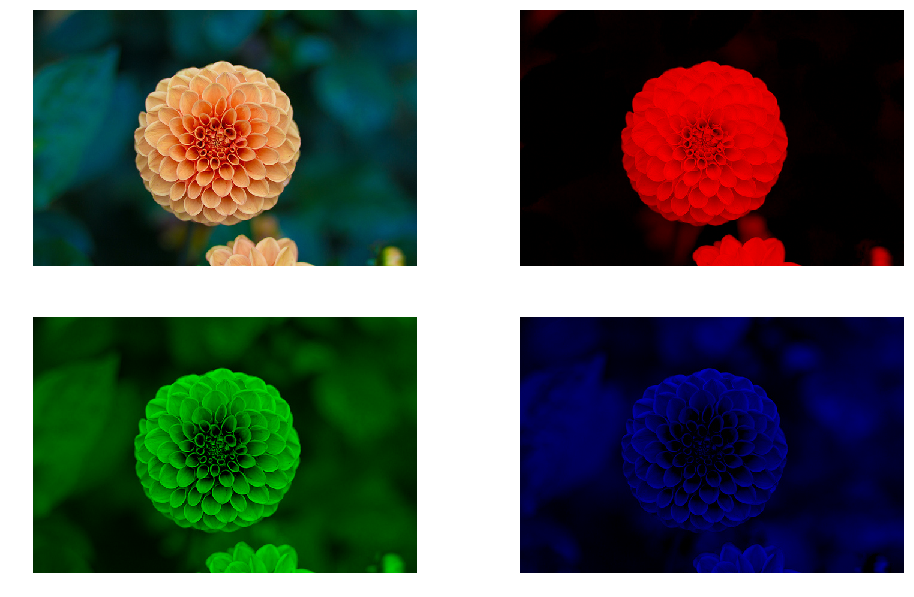

In [2]:
# get data set
dataset = datasets.load_sample_images()
rgb = dataset.images[1]

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def draw_images(images):
    """
    fit list of images in a squire
    """
    plt.figure(figsize=(16,16))
    n = len(images)
    side = math.sqrt(n)//1.0
    for idx, image in enumerate(images):
        plt.subplot(n//side + 1, n//side, idx + 1)
        plt.imshow(image.clip(min=0,max=1.0));
        plt.axis('off')

def draw_images_with_titles(images):
    """
    fit list of images in a squire
    """
    plt.figure(figsize=(16,16))
    n = len(images)
    side = math.sqrt(n)//1.0
    for idx, (title, image) in enumerate(images):
        plt.subplot(n//side + 1, n//side, idx + 1)
        plt.imshow(image);
        plt.title(title)
        plt.axis('off')

def extract_channel(rgb, channel):
    """
    would like to get R, G, B separately.
    TODO: maybe there is simpler way to do it
    """
    #return np.concatenate((np.expand_dims(np.identity(2), axis=2), np.zeros((2,2,2))), axis=2)
    rgb_copy = rgb.copy()
    for c in [0,1,2]:
        if c != channel:
            rgb_copy[..., c] = 0
    return rgb_copy

def normalize(matrix):
    sum = np.sum(matrix)
    if sum != 0.:
        return matrix / sum
    else:
        return matrix

img = rgb/255.0

reds = extract_channel(img, 0)
greens = extract_channel(img, 1)
blues = extract_channel(img, 2)
grey = rgb2gray(img)
draw_images([img, reds, greens, blues])


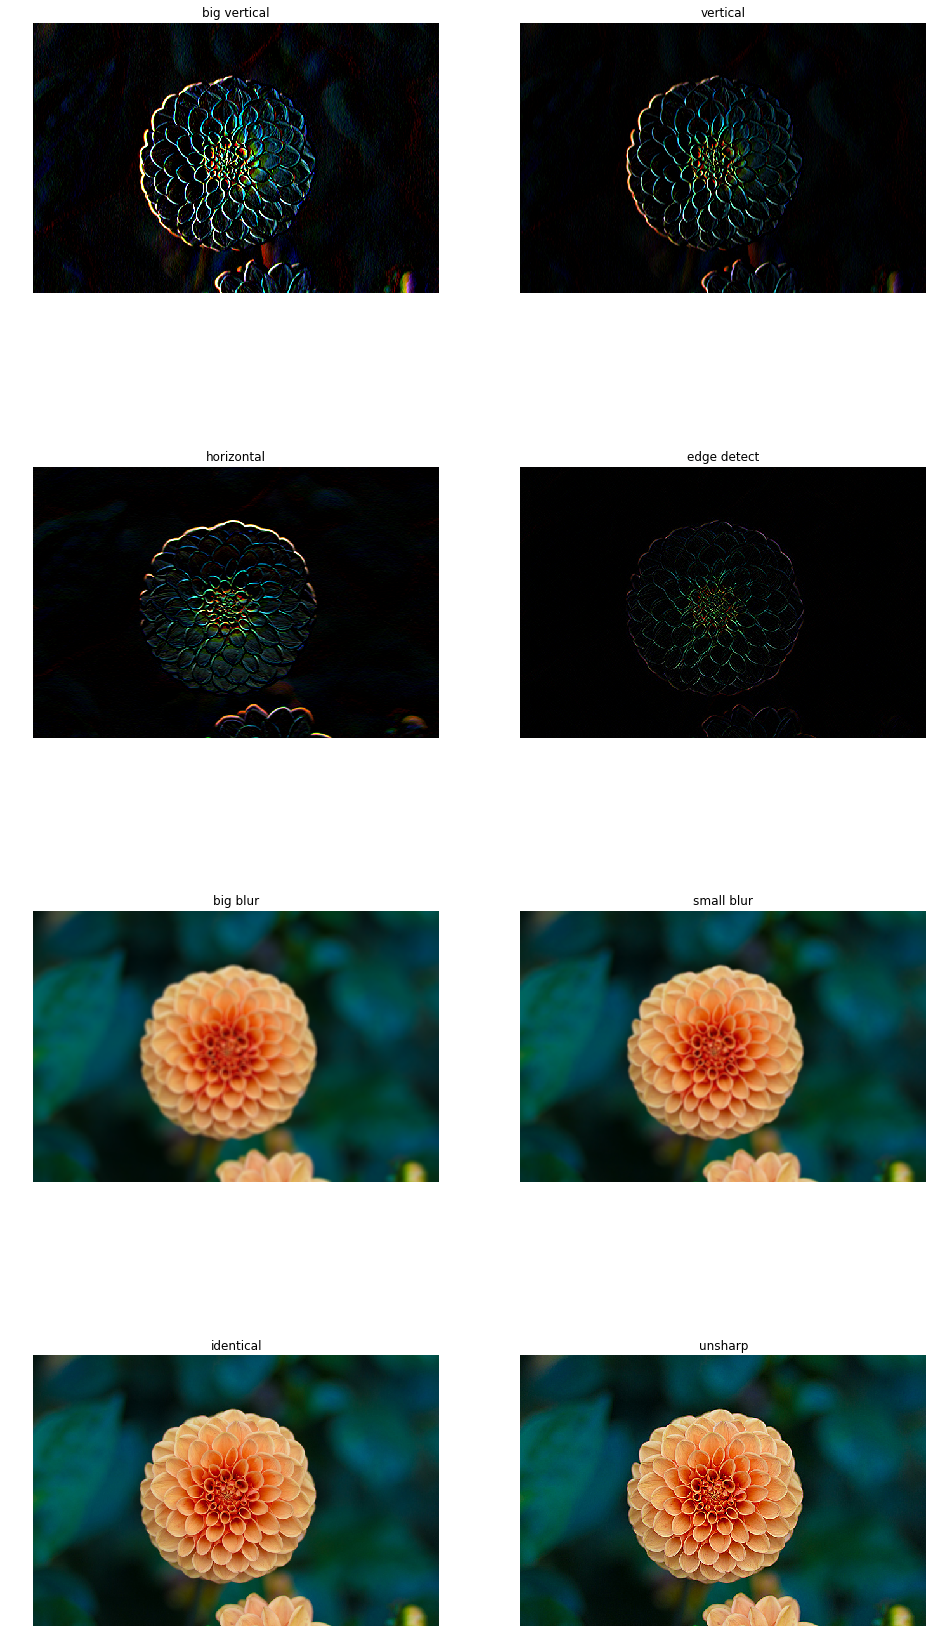

In [3]:
# apply filter

f_vertical_big = np.array([
    [0, 1, -1, 0],
    [1, 3, -3, -1],
    [1, 3, -3, -1],
    [0, 1, -1, 0],    
])

f_2 = np.array([
    [1,1,1],
    [0,0,0],
    [-1,-1,-1],    
])

f_vertical = np.array([
    [1,0,-1],
    [1,0,-1],
    [1,0,-1],    
])

# https://en.wikipedia.org/wiki/Unsharp_masking
f_contrast = np.array([
    [ 1, 4,   6, 4, 1],
    [ 4,16,  24,16, 4],
    [ 6,24,-476,24, 6],    
    [ 4,16,  24,16, 4],
    [ 1, 4,   6, 4, 1],
])

f_identical = np.array([
    [0,0,0],
    [0,1,0],
    [0,0,0],    
])

f_blur_big = np.array([
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
    [1,1,1,1,1,1],
])

f_blur_small = np.array([
    [1,1,1,1],
    [1,1,1,1],
    [1,1,1,1],
    [1,1,1,1],
])

# https://en.wikipedia.org/wiki/Edge_detection
kernel_edge_detect1 = np.array([[1.,0.,-1.],
                                [0.,0.,0.],
                                [-1.,0.,1.]])

def convolve_all_colours(im, window):
    """
    Convolves im with window, over all three colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = signal.convolve2d(im[:,:,d], window, mode="same", boundary="symm")
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2)#.astype("uint8")

    return im_conv

def convolute_filter(img, f, title):
# doesn't work corectly:
#     multi_channel_filter = np.array([f, np.zeros(f.shape), np.zeros(f.shape)]).T
#     multi_channel_filter = np.array([f, f, f])
#     multi_channel_filter = f
#     multi_channel_filter = normalize(multi_channel_filter)
#     filtered_img = ndimage.convolve(img[...,0], multi_channel_filter, mode='constant', cval=0.0)
    #filtered_img = ndimage.convolve(img, multi_channel_filter, mode='constant', cval=0.0)
    #filtered_img = signal.convolve(img, multi_channel_filter, method='direct')
    f = normalize(f)
    filtered_img = convolve_all_colours(img, f)
    plt.imshow(filtered_img.clip(0.0,1.0))
    plt.title(title)
    plt.axis('off')


filters = [
    ('big vertical', f_vertical_big),
    ('vertical', f_vertical),
    ('horizontal', f_2),
    ('edge detect', kernel_edge_detect1),
    ('big blur', f_blur_big),
    ('small blur', f_blur_small),
    ('identical', f_identical),
    ('unsharp', f_contrast),
]

plt.figure(figsize=(16,64))
for idx, (title, f) in enumerate(filters):
    plt.subplot(len(filters), len(filters) // 4, idx + 1)
    convolute_filter(img, f, title);

# Padding

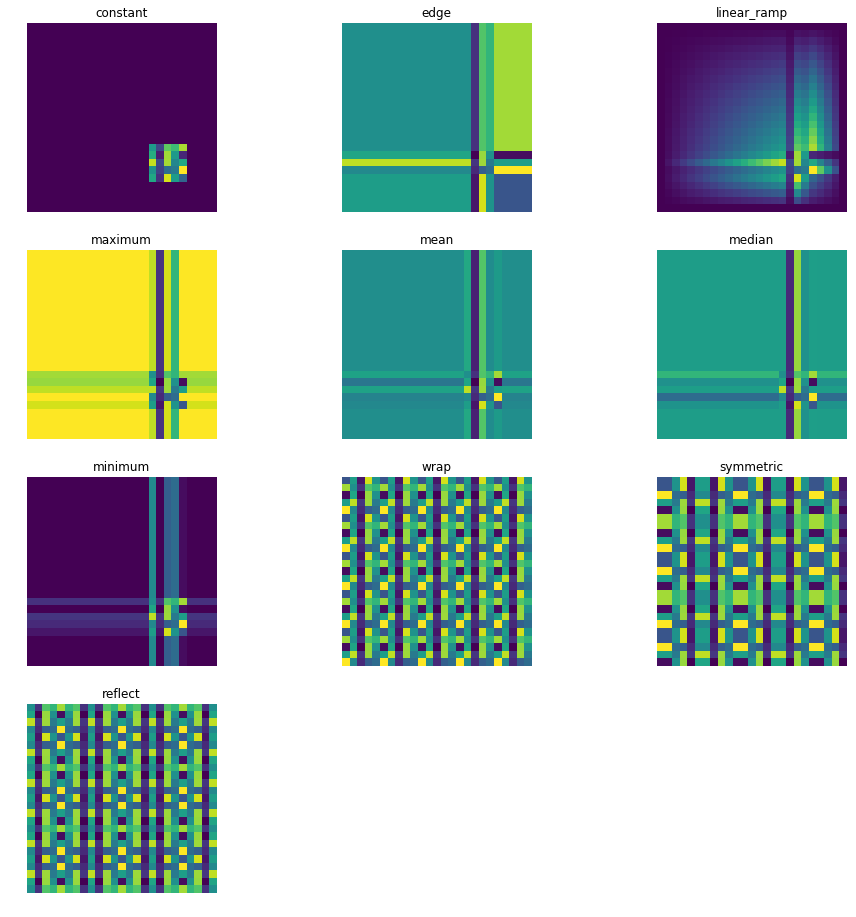

In [4]:
s = 5
a = np.random.rand(s,s)
b = 4
e = 16

cases = [
    ('constant', np.pad(a, (e,b,), 'constant')),
    ('edge', np.pad(a, (e,b,), 'edge')),
    ('linear_ramp', np.pad(a, (e,b,), 'linear_ramp')),
    ('maximum', np.pad(a, (e,b,), 'maximum')),
    ('mean', np.pad(a, (e,b,), 'mean')),
    ('median', np.pad(a, (e,b,), 'median')),
    ('minimum', np.pad(a, (e,b,), 'minimum')),
    ('wrap', np.pad(a, (e,b,), 'wrap')),
    ('symmetric', np.pad(a, (e,b,), 'symmetric')),    
    ('reflect', np.pad(a, (e,b,), 'reflect')),
]

draw_images_with_titles(cases)

## CNN for Tensorflow

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    # TODO: set placeholder
    #X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    #parameters = initialize_parameters()
    
    # TODO: set variables
    # W1 = tf.get_variable('W1', [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    
    # TODO: connect CNN
    # tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME')
    
    # TODO: pooling
    # tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    
    # TODO: use ReLu
    # tf.nn.relu(Z1)
    
    # TODO: Fully connected (FC) layer
    # tf.contrib.layers.flatten(P)
    # the fully connected layer automatically initializes weights in the graph 
    # and keeps on training them as you train the model. 
    # We did not need to initialize those weights when initializing the parameters.
    # tf.contrib.layers.fully_connected(F, num_outputs)
    
    # TODO: cost function
    # computes the softmax entropy loss. 
    # tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y): 
    # computes the mean of elements across dimensions of a tensor
    # tf.reduce_mean: 

    init = tf.global_variables_initializer()
    sess_test.run(init)
    #print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    #print("W2 = " + str(parameters["W2"].eval()[1,1,1]))